In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors, cm
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import trackpy as tp
from scipy.interpolate import UnivariateSpline
import random as rand
from tqdm import tqdm
import scipy.stats as stat

In [2]:
def read_tuple_list(x):
    x_strip = x.strip('()').strip('[]')
    if len(x_strip.split(', ')) == 1:
        return np.array(x_strip.split(), dtype=float)
    else:
        return np.array(x_strip.split(', '), dtype=float)

In [3]:
#Lets import an arcos set, wave data, and the corresponding tracking data...
base_path = Path.cwd().parent / 'Data Sets/2023_01_24_main-set'
images_folder = base_path / 'images'
analysis_output_destination = base_path / 'wavefit_outputs'

wave_paths = sorted(analysis_output_destination.glob('*_wave_df.csv'))
arcos_paths = sorted(analysis_output_destination.glob('*_ARCOS_df.csv'))
tracking_paths = sorted(analysis_output_destination.glob('*_tracking_binned_df.csv'))

In [5]:
#To run analysis: 
inner_means_collection = []
outer_means_collection =  []

in_track_count = 0
out_track_out = 0


with tqdm(total=len(wave_paths)) as pbar:
    for w_path, a_path, t_path in zip(wave_paths, arcos_paths, tracking_paths):
        #get image number from arcos df 
        im_num = int(a_path.stem.split('_')[0])
        #check that all dfs are the matching image number! 
        if np.all([path_num == im_num for path_num in [int(w_path.stem.split('_')[0]),int(t_path.stem.split('_')[0])]]):
            #build loop here:
            #Import all DFs associated with an image: 
            wave_df = pd.read_csv(w_path, converters={"wave_centroid": read_tuple_list})
            arcos_df = pd.read_csv(a_path)
            tracking_df = pd.read_csv(t_path)

            #Find biggest collective event to add to main analysis: 
            max_r_collection = {}

            for clid, cl_event in wave_df.groupby('clTrackID'):
                mean_centroid = cl_event.wave_centroid.values[0]
                #coords = np.stack((np.array(cl_event.x.values), np.array(cl_event.y.values)), axis=1)
                #radial_vec = [np.array([mean_centroid[0] - coords[i][0], mean_centroid[1] - coords[i][1]]) for i in range(len(coords))]
                #dist_from_center = np.linalg.norm(radial_vec, axis=1)*2.2
                max_r_collection[clid] = cl_event.circle_radius.values.max()

            biggest_event_r = max(max_r_collection.values())
            max_clids = [k for k, v in max_r_collection.items() if v == biggest_event_r] # getting all keys containing the `maximum`

            if len(max_clids) > 1:
                print('rarity in image {}'.format(im_num))
                continue

            #Get the arcos information for the largest event: 
            arcos_main =  arcos_df[arcos_df.clTrackID == max_clids[0]]

            #Collect tracking data for the duration of the wave plus 1min: 
            window_start = arcos_main['timepoint'].min()
            window_stop = arcos_main['timepoint'].max()

            tracks = tracking_df.groupby('track_id')

            #get the tracks that arcos says are inside the largest wave...
            track_collect = []
            outer_tracks = []

            for i, track in tracks: 
                if i in arcos_main.track_id.unique():
                    track_collect.append(track[track['timepoint'].between(window_start, window_stop)])
                else:
                    outer_tracks.append(track[track['timepoint'].between(window_start, window_stop)])

            tracks_in_wave = pd.concat(track_collect, ignore_index=True)
            tracks_out_wave = pd.concat(outer_tracks, ignore_index=True)


            #Time to calculate some values for all tracks:
            track_min_length = 5
            inner_collection = []
            tracks_group = tracks_in_wave.groupby('track_id')

            for track_id, track in tracks_group:

                if len(track) < track_min_length:
                    continue
                #Get the time, x, and y points --> Smooth x and y on time... 
                time = track.timepoint.values*5.0
                x_smooth = UnivariateSpline(time, track.x.values, s=5)
                y_smooth = UnivariateSpline(time, track.y.values, s=5)

                #Compile as coords, get the linear velocity vectors, radial vectors, distance from center of the wave, velocity, angle between velocity and center radius, Chemotactic index, and radial velocity:
                coords = np.stack((np.array(x_smooth(time)), np.array(y_smooth(time))), axis=1)
                radial_vec = [np.array([mean_centroid[0] - coords[i][0], mean_centroid[1] - coords[i][1]]) for i in range(len(coords))]
                dist_from_center = np.linalg.norm(radial_vec, axis=1)*2.2
                lin_velocity_vec = [(coords[i+1] - coords[i])/5.0 for i in range(len(coords)-1)]
                radial_vec = [np.array([mean_centroid[0] - coords[i][0], mean_centroid[1] - coords[i][1]]) for i in range(len(coords))]
                dist_from_center = np.linalg.norm(radial_vec, axis=1)*2.2
                velocity = np.linalg.norm(lin_velocity_vec, axis=1)*2.2*60.0 #px/s --> um/s --> um/min
                angles = [np.arctan2(np.linalg.norm(np.cross(radial_vec[i], lin_velocity_vec[i])), np.dot(radial_vec[i], lin_velocity_vec[i])) for i in range(len(lin_velocity_vec))]
                cis = np.cos(angles)
                radial_velocity = velocity*cis

                #Append the relevant parameters to the track: 
                inner_collection.append(np.mean(radial_velocity))


            #Repeat for the tracks outside the largest wave: 
            out_group = tracks_out_wave.groupby('track_id')
            outer_collection = []

            for track_id, track in out_group:

                if len(track) < track_min_length:
                    continue

                #Get the time, x, and y points --> Smooth x and y on time... 
                time = track.timepoint.values*5.0
                x_smooth = UnivariateSpline(time, track.x.values, s=5)
                y_smooth = UnivariateSpline(time, track.y.values, s=5)

                #Compile as coords, get the linear velocity vectors, radial vectors, distance from center of the wave, velocity, angle between velocity and center radius, Chemotactic index, and radial velocity:
                coords = np.stack((np.array(x_smooth(time)), np.array(y_smooth(time))), axis=1)
                radial_vec = [np.array([mean_centroid[0] - coords[i][0], mean_centroid[1] - coords[i][1]]) for i in range(len(coords))]
                dist_from_center = np.linalg.norm(radial_vec, axis=1)*2.2
                lin_velocity_vec = [(coords[i+1] - coords[i])/5.0 for i in range(len(coords)-1)]
                radial_vec = [np.array([mean_centroid[0] - coords[i][0], mean_centroid[1] - coords[i][1]]) for i in range(len(coords))]
                dist_from_center = np.linalg.norm(radial_vec, axis=1)*2.2
                velocity = np.linalg.norm(lin_velocity_vec, axis=1)*2.2*60.0 #px/s --> um/s --> um/min
                angles = [np.arctan2(np.linalg.norm(np.cross(radial_vec[i], lin_velocity_vec[i])), np.dot(radial_vec[i], lin_velocity_vec[i])) for i in range(len(lin_velocity_vec))]
                cis = np.cos(angles)
                radial_velocity = velocity*cis
                
                outer_collection.append(np.mean(radial_velocity))


            inner_means_collection.append(np.mean(inner_collection))
            outer_means_collection.append(np.mean(outer_collection))
            pbar.update(1)

            
big_df = pd.concat([pd.DataFrame({'track_status': 'outer', 'mean_movement': outer_means_collection}), pd.DataFrame({'track_status': 'inner', 'mean_movement': inner_means_collection})])


  0%|                                                      | 0/57 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [6]:
#TO SAVE ANALYSIS ABOVE: 
#big_df.to_csv('fig1_all-waves_inner-outer_relation.csv')
#TO LOAD ANALYSIS ABOVE: 
big_df = pd.read_csv('fig1_all-waves_inner-outer_relation.csv')

In [7]:
big_df[big_df['track_status'] == 'inner']['mean_movement'].values

array([1.54504037, 3.22015793, 2.53793752, 5.02415026, 8.20277188,
       3.33405294, 3.00900634, 5.43375649, 7.00467057, 3.61588234,
       7.30637247, 6.0359725 , 3.55438901, 3.73875822, 4.86826176,
       5.59893246, 6.08727198, 5.71788282, 4.60762317, 2.83665474,
       4.47115202, 5.80314189, 1.43915423, 2.66907413, 1.75995623,
       4.53397899, 7.14075907, 5.01008338, 2.82331793, 4.47472255,
       7.4527536 , 4.8506258 , 3.4168785 , 3.68615399, 3.95104855,
       2.51220181, 6.32342092, 6.75684778, 3.23519895, 3.94696523,
       7.30869902, 4.02186489, 2.02961057, 5.90489418, 4.64039816,
       0.96663368, 2.7415955 , 1.64586098, 0.42022514, 7.950988  ,
       4.57305793, 4.59064587, 3.83289003, 2.71970654, 2.71007842,
       1.76065896, 4.98299808])

In [8]:
#t-test model between inner and outer movement generally: 

inners = big_df[big_df['track_status'] == 'inner']['mean_movement'].values
outers = big_df[big_df['track_status'] == 'outer']['mean_movement'].values


stat.ttest_rel(inners, outers)

TtestResult(statistic=19.801404310690682, pvalue=5.817265672646437e-27, df=56)

In [9]:
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2, 'font.family': ['arial'], 'axes.linewidth':2})

/var/folders/jb/q2707w2155s00qd5b8lpx_6m0000gn/T/ipykernel_17446/1435783174.py:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(np.zeros(len(outers)), outers, c=sns.color_palette()[7], alpha=0.2)
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

(-1.5, 9.75)

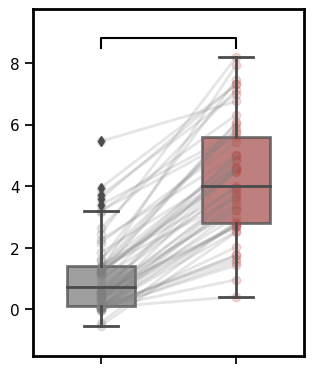

In [10]:
plt.figure(figsize=(3.5,4.5))

# plotting the points
plt.scatter(np.zeros(len(outers)), outers, c=sns.color_palette()[7], alpha=0.2)
plt.scatter(np.ones(len(inners)), inners, c="#B54845", alpha=0.2)

# plotting the lines
for i in range(len(inners)):
    plt.plot( [0,1], [outers[i], inners[i]], c=sns.color_palette()[7], alpha=0.2)


ax = sns.boxplot(data=big_df, x='track_status', y='mean_movement', orient='v', palette=[sns.color_palette()[7], "#B54845"], width=0.5, boxprops=dict(alpha=.75))
ax.set_xticklabels(['', ''])
plt.xlabel('')
plt.ylabel('')

# statistical annotation
x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = 8.5, 0.3, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "", ha='center', va='bottom', color=col)
plt.ylim(-1.5,9.75)

#TO SAVE FIGURE FOR PLOTTING UNCOMMENT: 
#plt.savefig('fig-1-radial-movement-averages.png', bbox_inches='tight', dpi=300)